In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

### **Set Constants**

In [5]:
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
DATASET_DIR = "C:\\Users\\tejes\\OneDrive\\Pictures\\Documents\\Desktop\\miniProject"
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 250
FINE_TUNE_POINT = 125
LEARNING_RATE = 0.001

img_height = 128
img_width = 128


### **Load Image Datasets**

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

Found 2521 files belonging to 5 classes.
Using 2017 files for training.
Found 2521 files belonging to 5 classes.
Using 504 files for validation.


In [7]:
class_names = train_ds.class_names

In [8]:
for example_image, example_label in train_ds.take(1):
  break

print(f"Image Shape: {example_image.shape}")

Image Shape: (32, 128, 128, 3)


### **Split Validation Dataset into a Validation DS and Test DS**

In [9]:
validation_ds = validation_ds.shard(num_shards=2, index=0)
test_ds = validation_ds.shard(num_shards=2, index=1)

### **Visualize a Set of Training Data**

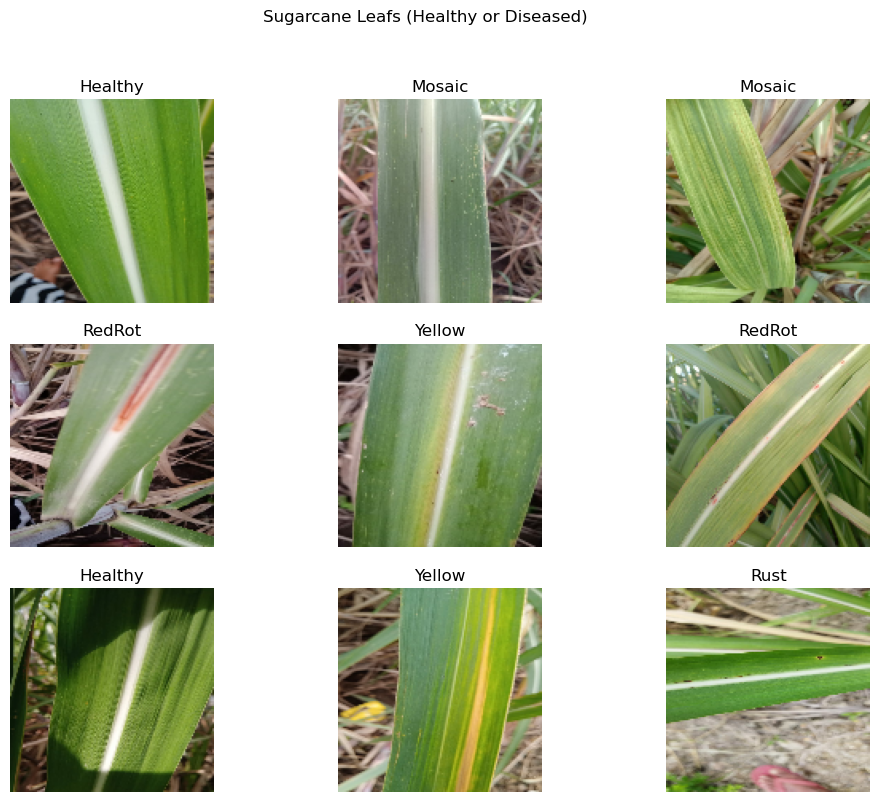

In [10]:
plt.figure(figsize=(12, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.suptitle("Sugarcane Leafs (Healthy or Diseased)")
        plt.axis("off")

In [11]:
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### **Load Base Model**

In [12]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

print(len(base_model.layers))

154


In [13]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
  layer.trainable = False

### **Create the Classification Model**

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### **Fit the Model**

In [16]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
)

Epoch 1/50
64/64 [==============================] - 67s 712ms/step - loss: 0.8659 - accuracy: 0.7100 - val_loss: 3.4260 - val_accuracy: 0.6016
Epoch 2/50
64/64 [==============================] - 51s 796ms/step - loss: 0.3607 - accuracy: 0.8860 - val_loss: 9.3209 - val_accuracy: 0.3594
Epoch 3/50
64/64 [==============================] - 51s 800ms/step - loss: 0.1937 - accuracy: 0.9405 - val_loss: 10.3796 - val_accuracy: 0.5156
Epoch 4/50
64/64 [==============================] - 49s 766ms/step - loss: 0.1619 - accuracy: 0.9494 - val_loss: 8.3059 - val_accuracy: 0.4570
Epoch 5/50
64/64 [==============================] - 43s 665ms/step - loss: 0.1530 - accuracy: 0.9569 - val_loss: 19.4350 - val_accuracy: 0.2773
Epoch 6/50
64/64 [==============================] - 44s 693ms/step - loss: 0.1587 - accuracy: 0.9489 - val_loss: 12.5533 - val_accuracy: 0.4844
Epoch 7/50
64/64 [==============================] - 55s 866ms/step - loss: 0.0813 - accuracy: 0.9772 - val_loss: 8.7340 - val_accuracy: 0.5

### **Classification Report**

Text(0.5, 0, 'Epoch')

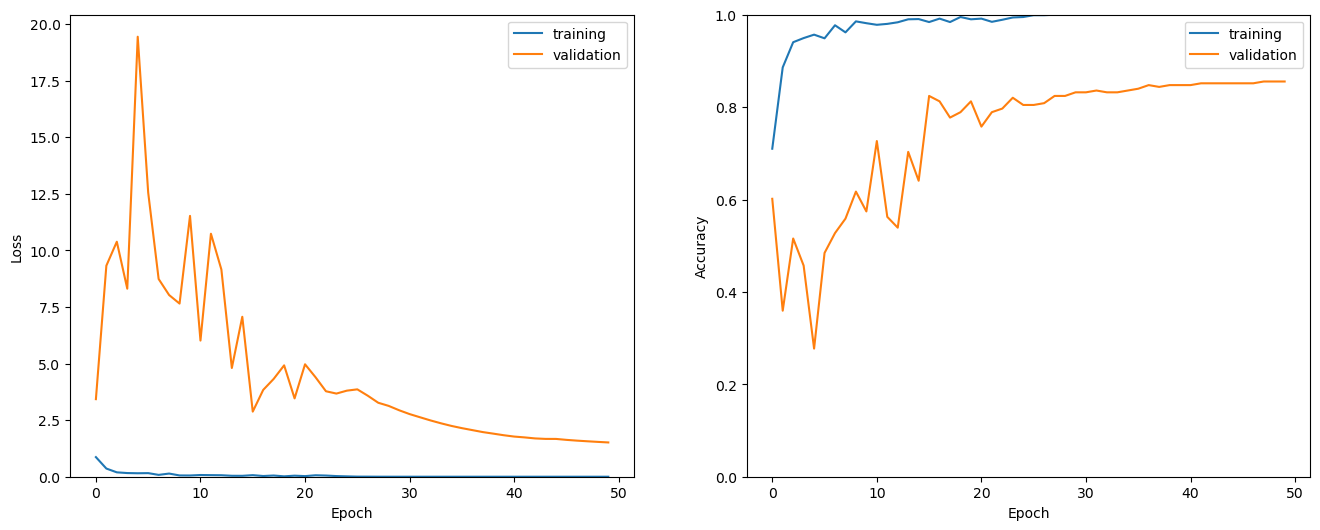

In [17]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [18]:
model.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 2s 308ms/step - loss: 1.6927 - accuracy: 0.8672


{'loss': 1.6926548480987549, 'accuracy': 0.8671875}

In [19]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

4/4 [==============================] - 3s 289ms/step


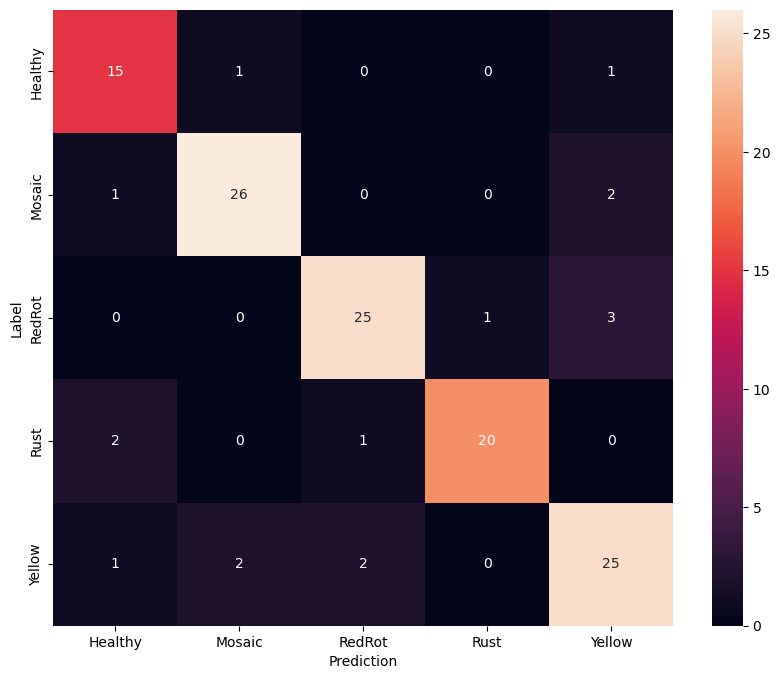

In [20]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, classification_report

# Predicting labels for the test dataset
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(class_report)


4/4 [==============================] - 1s 290ms/step
Accuracy: 0.8671875
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.79      0.88      0.83        17
      Mosaic       0.90      0.90      0.90        29
      RedRot       0.89      0.86      0.88        29
        Rust       0.95      0.87      0.91        23
      Yellow       0.81      0.83      0.82        30

    accuracy                           0.87       128
   macro avg       0.87      0.87      0.87       128
weighted avg       0.87      0.87      0.87       128



In [22]:
import pickle

# Pickle the model
with open('MobileNetV21.pkl', 'wb') as f:
    pickle.dump(model, f)


In [23]:
# Load the pickled model
import pickle

with open('MobileNetV21.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [24]:
from sklearn.metrics import accuracy_score, classification_report

# Predicting labels for the test dataset
y_pred = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(class_report)


4/4 [==============================] - 3s 291ms/step
Accuracy: 0.8671875
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.79      0.88      0.83        17
      Mosaic       0.90      0.90      0.90        29
      RedRot       0.89      0.86      0.88        29
        Rust       0.95      0.87      0.91        23
      Yellow       0.81      0.83      0.82        30

    accuracy                           0.87       128
   macro avg       0.87      0.87      0.87       128
weighted avg       0.87      0.87      0.87       128



## SPATIAL MODEL

In [31]:
# Define the spatial attention layer
@tf.keras.utils.register_keras_serializable()
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.convolution = tf.keras.layers.Conv2D(filters=1,
                                                  kernel_size=(1, 1),
                                                  strides=(1, 1),
                                                  padding='same',
                                                  activation='sigmoid')

    def call(self, inputs):
        attention = self.convolution(inputs)
        return inputs * attention

In [32]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True


In [33]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
    layer.trainable = False


In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    SpatialAttention(),  # Add spatial attention layer
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [35]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)



In [36]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
)


Epoch 1/50
64/64 [==============================] - 45s 511ms/step - loss: 0.8584 - accuracy: 0.7105 - val_loss: 5.9889 - val_accuracy: 0.4648
Epoch 2/50
64/64 [==============================] - 30s 475ms/step - loss: 0.3511 - accuracy: 0.8775 - val_loss: 7.9150 - val_accuracy: 0.4531
Epoch 3/50
64/64 [==============================] - 30s 476ms/step - loss: 0.2217 - accuracy: 0.9351 - val_loss: 9.2870 - val_accuracy: 0.5586
Epoch 4/50
64/64 [==============================] - 30s 466ms/step - loss: 0.2309 - accuracy: 0.9296 - val_loss: 7.4978 - val_accuracy: 0.5430
Epoch 5/50
64/64 [==============================] - 36s 572ms/step - loss: 0.1417 - accuracy: 0.9559 - val_loss: 7.8237 - val_accuracy: 0.6055
Epoch 6/50
64/64 [==============================] - 34s 539ms/step - loss: 0.1190 - accuracy: 0.9703 - val_loss: 7.9984 - val_accuracy: 0.5391
Epoch 7/50
64/64 [==============================] - 35s 542ms/step - loss: 0.0893 - accuracy: 0.9767 - val_loss: 5.9864 - val_accuracy: 0.6523

In [37]:
model.evaluate(validation_ds)


8/8 [==============================] - 4s 454ms/step - loss: 1.1322 - accuracy: 0.8672


[1.1321933269500732, 0.8671875]

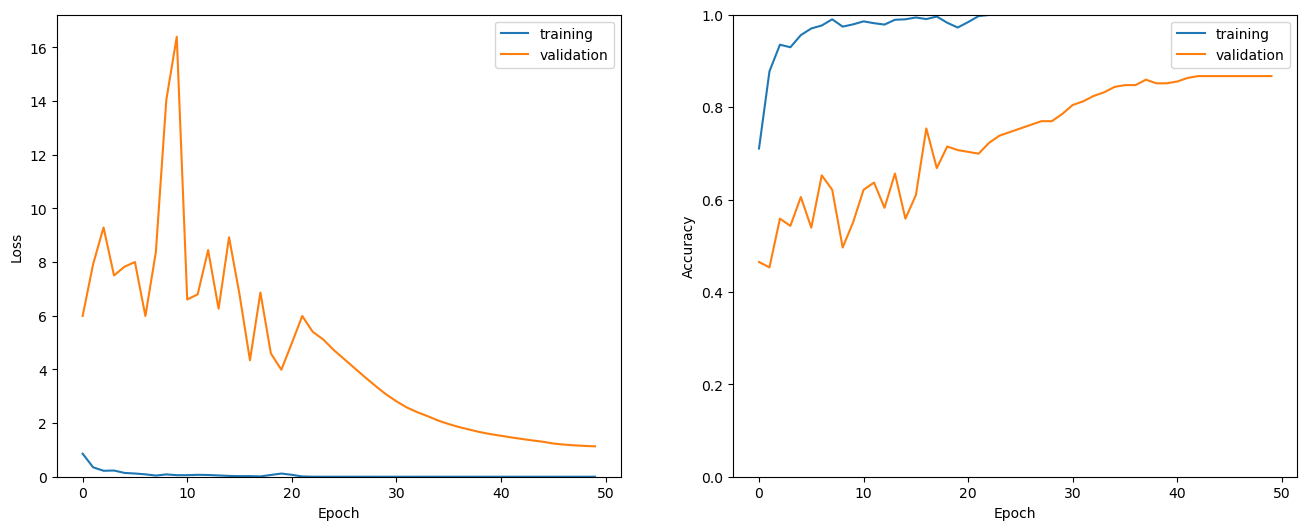

In [38]:
# Plot training history
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

In [50]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

4/4 [==============================] - 1s 320ms/step


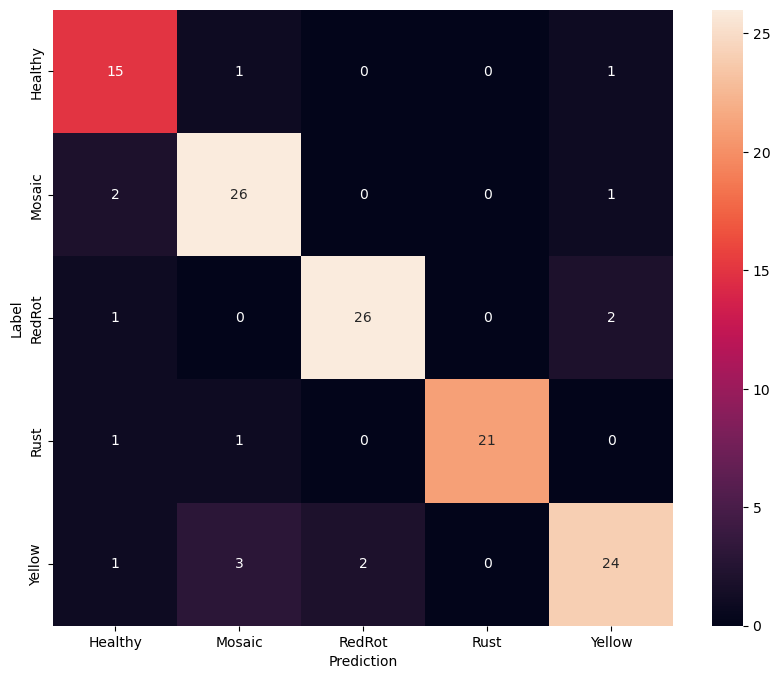

In [51]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [39]:
from sklearn.metrics import accuracy_score, classification_report

# Predicting labels for the test dataset
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(class_report)


4/4 [==============================] - 4s 578ms/step
Accuracy: 0.875
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.75      0.88      0.81        17
      Mosaic       0.84      0.90      0.87        29
      RedRot       0.93      0.90      0.91        29
        Rust       1.00      0.91      0.95        23
      Yellow       0.86      0.80      0.83        30

    accuracy                           0.88       128
   macro avg       0.87      0.88      0.87       128
weighted avg       0.88      0.88      0.88       128



In [40]:
import pickle

# Pickle the model
with open('MobileNetV2_Spatial_attention.pkl', 'wb') as f:
    pickle.dump(model, f)

In [41]:
# Load the pickled model
import pickle

with open('MobileNetV2_Spatial_attention.pkl', 'rb') as f:
    loaded_model_spatial = pickle.load(f)


In [42]:
from sklearn.metrics import accuracy_score, classification_report

# Predicting labels for the test dataset
y_pred = loaded_model_spatial.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(class_report)

4/4 [==============================] - 4s 502ms/step
Accuracy: 0.875
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.75      0.88      0.81        17
      Mosaic       0.84      0.90      0.87        29
      RedRot       0.93      0.90      0.91        29
        Rust       1.00      0.91      0.95        23
      Yellow       0.86      0.80      0.83        30

    accuracy                           0.88       128
   macro avg       0.87      0.88      0.87       128
weighted avg       0.88      0.88      0.88       128



# ENSEMBLING 

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [45]:
def ensemble_stack_model(loaded_model, loaded_model_spatial):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    sequential_output = loaded_model(inputs)
    spatial_attention_output = loaded_model_spatial(inputs)
    concatenated = layers.Concatenate()([sequential_output, spatial_attention_output])
    outputs = layers.Dense(5, activation='softmax')(concatenated)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [46]:
ensemble_model = ensemble_stack_model(loaded_model,loaded_model_spatial)


In [47]:
# Compile the ensemble stack model
ensemble_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
ensemble_history = ensemble_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=40
)

Epoch 1/40
64/64 [==============================] - 120s 2s/step - loss: 0.2670 - accuracy: 0.9613 - val_loss: 7.0956 - val_accuracy: 0.7969
Epoch 2/40
64/64 [==============================] - 80s 1s/step - loss: 0.0630 - accuracy: 0.9871 - val_loss: 5.2514 - val_accuracy: 0.7852
Epoch 3/40
64/64 [==============================] - 89s 1s/step - loss: 0.0846 - accuracy: 0.9787 - val_loss: 3.7013 - val_accuracy: 0.8164
Epoch 4/40
64/64 [==============================] - 86s 1s/step - loss: 0.1180 - accuracy: 0.9772 - val_loss: 2.1865 - val_accuracy: 0.8789
Epoch 5/40
64/64 [==============================] - 80s 1s/step - loss: 0.0411 - accuracy: 0.9881 - val_loss: 3.6890 - val_accuracy: 0.8320
Epoch 6/40
64/64 [==============================] - 84s 1s/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 4.4230 - val_accuracy: 0.8125
Epoch 7/40
64/64 [==============================] - 83s 1s/step - loss: 0.0137 - accuracy: 0.9970 - val_loss: 3.6962 - val_accuracy: 0.8438
Epoch 8/40
64/64 [=

In [52]:
ensemble_model.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 2s 527ms/step - loss: 1.6121 - accuracy: 0.8984


{'loss': 1.6120944023132324, 'accuracy': 0.8984375}

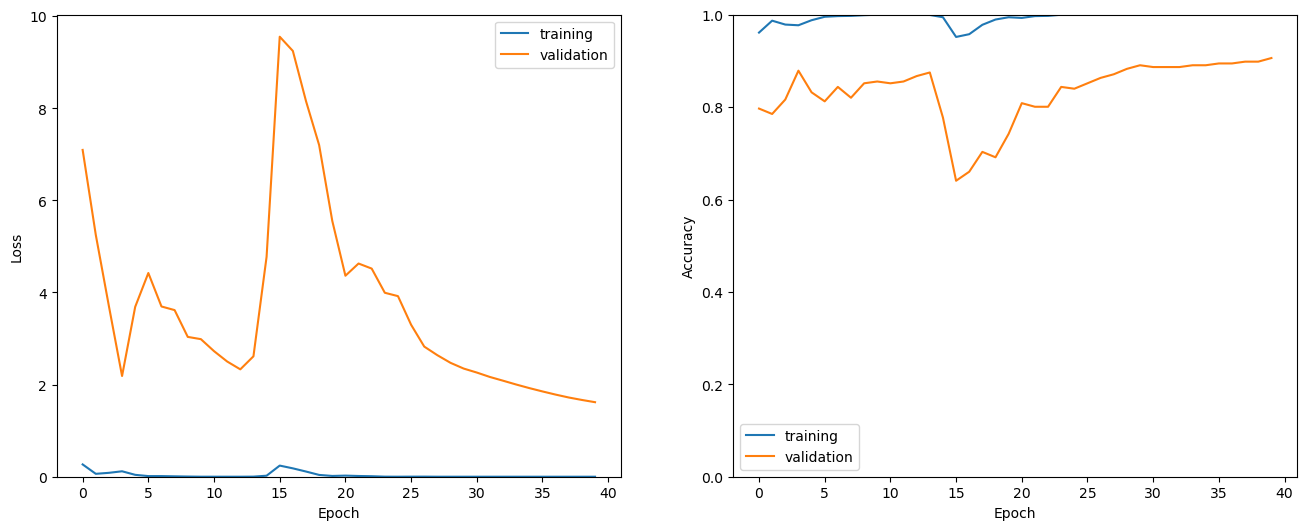

In [56]:
metrics = ensemble_history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(ensemble_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(ensemble_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

In [53]:
from sklearn.metrics import accuracy_score, classification_report

# Predicting labels for the test dataset
y_pred = ensemble_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(class_report)


4/4 [==============================] - 5s 500ms/step
Accuracy: 0.8984375
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.74      1.00      0.85        17
      Mosaic       0.96      0.93      0.95        29
      RedRot       0.93      0.90      0.91        29
        Rust       0.96      0.96      0.96        23
      Yellow       0.88      0.77      0.82        30

    accuracy                           0.90       128
   macro avg       0.89      0.91      0.90       128
weighted avg       0.91      0.90      0.90       128



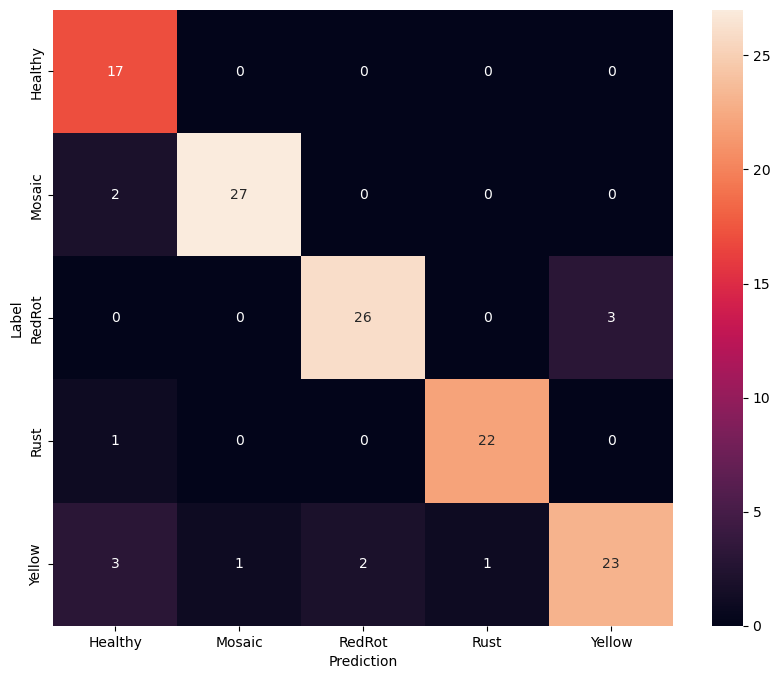

In [54]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()